Initially each customer will be scored based on RFM model

R: Recency : more recent purchases more recency score

F: Frequency : more frequent purchases more frequency score

M: Monetary : more amount spent more monetary score

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
rtl_df = pd.read_csv('Online Retail.csv',encoding = 'unicode_escape')
rtl_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [22]:
rtl_df.shape

(541909, 8)

In [26]:
customer_country = rtl_df[['CustomerID','Country']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID',ascending=False)

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


In [27]:
#90% of data is only for UK so performing customer segmentation on only UK's data
rtl_df = rtl_df.query("Country=='United Kingdom'").reset_index(drop=True)

In [28]:
rtl_df.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

In [31]:
#Remove missing values for customer ID column and ignore missing values for description column
rtl_df = rtl_df[pd.notnull(rtl_df['CustomerID'])]

In [32]:
#Check quantity and price for negative values
print('Min Quantity',rtl_df.Quantity.min())
print('Min Price',rtl_df.UnitPrice.min())

Min Quantity -80995
Min Price 0.0


Quantity cannot be negative so drop these values. We are doing customer segmentation not analysis. For analysis we would have filled the missing values and corrected other columns. But for segmnetation we need correct data.

In [33]:
rtl_df = rtl_df[(rtl_df['Quantity']>0)]

In [34]:
type(rtl_df['InvoiceDate'][0])

str

In [35]:
#Converting date from string to datetime
rtl_df['InvoiceDate']=pd.to_datetime(rtl_df['InvoiceDate'])

In [36]:
rtl_df['TotalAmount'] = rtl_df['Quantity']*rtl_df['UnitPrice']

In [37]:
rtl_df.shape

(354345, 9)

In [38]:
rtl_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [40]:
rtl_df['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

# RFM Modeling

Recency: Latest date - Invoice date

Frequency: No. of transactions

Monetary: Sum of total amount

In [42]:
import datetime as dt

#Set latest date as 2011-12-10 as the latest invoice date is 2011-12-09
latest_date = dt.datetime(2011,12,10)

In [44]:
#RMF model for each customer
RMF = rtl_df.groupby('CustomerID').aggregate({'InvoiceDate': lambda x:(latest_date - x.max()).days,
                                             'InvoiceNo': lambda x:len(x),
                                             'TotalAmount': lambda  x:x.sum()})

RMF['InvoiceDate'] = RMF['InvoiceDate'].astype(int)

RMF.rename(columns = {'InvoiceDate':'Recency',
                     'InvoiceNo': 'Frequency',
                     'TotalAmount': 'Monetary'},inplace = True)

RMF.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,103,4196.01
2,12748.0,0,4596,33719.73
3,12749.0,3,199,4090.88
4,12820.0,3,59,942.34


In [45]:
#Describe recency
RMF.Recency.describe()

count    3921.000000
mean       91.722265
std        99.528532
min         0.000000
25%        17.000000
50%        50.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

In [65]:
RMF.Frequency.describe()

count    3921.000000
mean       90.371079
std       217.796155
min         1.000000
25%        17.000000
50%        41.000000
75%        99.000000
max      7847.000000
Name: Frequency, dtype: float64

In [66]:
RMF.Monetary.describe()

count      3921.000000
mean       1863.910113
std        7481.922217
min           0.000000
25%         300.040000
50%         651.820000
75%        1575.890000
max      259657.300000
Name: Monetary, dtype: float64

C:\Users\dkg27\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\dkg27\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\dkg27\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\dkg27\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


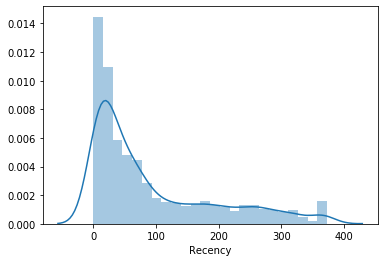

In [67]:
import seaborn as sns
sns.distplot(RMF['Recency'])

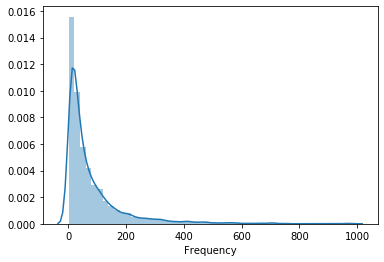

In [70]:
sns.distplot(RMF.query('Frequency<1000')['Frequency'])

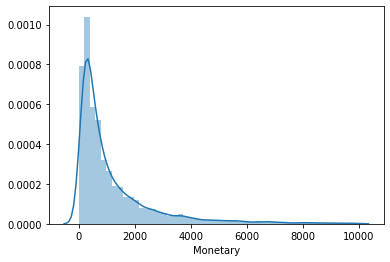

In [73]:
sns.distplot(RMF.query('Monetary<10000')['Monetary'])

In [74]:
#Split RMF data into 3 categories using quantiles
quantiles = RMF.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.0},
 'Monetary': {0.25: 300.03999999999996, 0.5: 651.8199999999999, 0.75: 1575.89}}

In [76]:
#Functions to score RFM

def Rscore(value,quantile_dict):
    if value<=quantile_dict['Recency'][0.25]:
        return 1
    elif value<=quantile_dict['Recency'][0.5]:
        return 2
    elif value<=quantile_dict['Recency'][0.75]:
        return 3
    else:
        return 4
    
def FMscore(value,column,quantile_dict):
    if value<=quantile_dict[column][0.25]:
        return 4
    elif value<=quantile_dict[column][0.5]:
        return 3
    elif value<=quantile_dict[column][0.75]:
        return 2
    else:
        return 1

In [81]:
RMF['Rscore'] = RMF['Recency'].apply(Rscore,args=(quantiles,))
RMF['Fscore'] = RMF['Frequency'].apply(FMscore,args=('Frequency',quantiles,))
RMF['Mscore'] = RMF['Monetary'].apply(FMscore,args=('Monetary',quantiles,))

In [82]:
RMF.head()

,Recency,Frequency,Monetary,Rscore,Fscore,Mscore
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12747.0,2,103,4196.01,1,1,1
12748.0,0,4596,33719.73,1,1,1
12749.0,3,199,4090.88,1,1,1
12820.0,3,59,942.34,1,2,2


In [83]:
#Concatenated score of RFM
RMF['RFM_Group'] = RMF.Rscore.map(str)+RMF.Fscore.map(str)+RMF.Mscore.map(str)

#Sum of RFM
RMF['RFM_Score'] = RMF[['Rscore','Fscore','Mscore']].sum(axis=1)

RMF.head()

,Recency,Frequency,Monetary,Rscore,Fscore,Mscore,RFM_Group,RFM_Score
CustomerID,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9
12747.0,2,103,4196.01,1,1,1,111,3
12748.0,0,4596,33719.73,1,1,1,111,3
12749.0,3,199,4090.88,1,1,1,111,3
12820.0,3,59,942.34,1,2,2,122,5


In [84]:
Loyalty_level = ['platinum','gold','silver','bronze']
score_cut = pd.qcut(RMF.RFM_Score, q=4 , labels = Loyalty_level)
RMF['Loyalty_level'] = score_cut.values

,Recency,Frequency,Monetary,Rscore,Fscore,Mscore,RFM_Group,RFM_Score,Loyalty_level
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,9,silver
12747.0,2,103,4196.01,1,1,1,111,3,platinum
12748.0,0,4596,33719.73,1,1,1,111,3,platinum
12749.0,3,199,4090.88,1,1,1,111,3,platinum
12820.0,3,59,942.34,1,2,2,122,5,platinum


In [85]:
RMF.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,Rscore,Fscore,Mscore,RFM_Group,RFM_Score,Loyalty_level
0,12346.0,325,1,77183.60,4,4,1,441,9,silver
1,12747.0,2,103,4196.01,1,1,1,111,3,platinum
2,12748.0,0,4596,33719.73,1,1,1,111,3,platinum
3,12749.0,3,199,4090.88,1,1,1,111,3,platinum
4,12820.0,3,59,942.34,1,2,2,122,5,platinum


In [86]:
RMF[RMF['RFM_Group']=='111'].sort_values('Monetary',ascending=False).reset_index().head(10)

,CustomerID,Recency,Frequency,Monetary,Rscore,Fscore,Mscore,RFM_Group,RFM_Score,Loyalty_level
0,18102.0,0,431,259657.30,1,1,1,111,3,platinum
1,17450.0,8,337,194550.79,1,1,1,111,3,platinum
2,17511.0,2,963,91062.38,1,1,1,111,3,platinum
3,16684.0,4,277,66653.56,1,1,1,111,3,platinum
4,14096.0,4,5111,65164.79,1,1,1,111,3,platinum
5,13694.0,3,568,65039.62,1,1,1,111,3,platinum
6,15311.0,0,2379,60767.90,1,1,1,111,3,platinum
7,13089.0,2,1818,58825.83,1,1,1,111,3,platinum
8,15769.0,7,130,56252.72,1,1,1,111,3,platinum
9,15061.0,3,403,54534.14,1,1,1,111,3,platinum


Customers with Loyalty level of platinum are the best customers. We can offer some new deals or membership to these customers

Customers with group 444 should be provided with some coupons to increase sales

In [88]:
RMF.reset_index().to_csv('RFM.csv',index=False)